# Conformal Experiment: Gradual Overlap OvA

In [1]:
import json

import numpy as np
import torch
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
n_classes = 10
n_experts = 10

In [3]:
# === OvA ===
confs = []
exps = []
true = []
path = "ova_gradual_overlap/"

p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
for p in p_out:
    model_name = '_p_out_' + str(p)
    with open(path + 'confidence_multiple_experts' + model_name + '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    # DANI Correction ===
    c = c.sigmoid()
    # DANI Correction ===
    confs.append(c)

### Check dimensions

In [4]:
# 1 expert rando, 3 with prob 0.95 correct
probs = confs[-3]
experts = exps[-3]
# experts = experts[::-1]  # reverse order!
y_true = true[-3]

In [5]:
print("Probs: {}".format(probs[:5,10:]))

Probs: tensor([[0.7706, 0.8100, 0.8257, 0.9983, 0.8172, 0.8258, 0.8391, 0.8708, 0.8466,
         0.8249],
        [0.7988, 0.8914, 0.7689, 0.8054, 0.8098, 0.8391, 0.7974, 0.7892, 0.9982,
         0.7808],
        [0.8081, 0.8260, 0.7705, 0.8161, 0.8147, 0.8487, 0.8144, 0.7984, 0.9964,
         0.7825],
        [0.9830, 0.8006, 0.8377, 0.8116, 0.8333, 0.8251, 0.8340, 0.8172, 0.8179,
         0.8466],
        [0.8038, 0.8473, 0.8304, 0.8290, 0.8368, 0.8193, 0.9943, 0.8433, 0.8559,
         0.8173]])


In [6]:
print("Experts: \n{}".format(np.array(experts)))

Experts: 
[[3 8 8 ... 2 9 5]
 [3 3 8 ... 2 9 0]
 [3 8 5 ... 2 9 5]
 ...
 [3 2 8 ... 2 9 5]
 [3 8 8 ... 2 9 5]
 [3 8 2 ... 2 9 2]]


In [7]:
print("Y True: \n{}".format(y_true[:5]))

Y True: 
[3, 8, 8, 0, 6]


In [8]:
n_val = int(0.8 * len(y_true))
n_test = len(y_true) - n_val
print("N val:{}".format(n_val))
print("N test:{}".format(n_test))

N val:7372
N test:1844


# Conformal Q_hat Calculation

In [ ]:

n_classes_exp = n_classes + n_experts
probs_val = probs[:n_val, 10:]
experts_val = experts
experts_val = [exp[:n_val] for exp in experts_val]

y_true_val = y_true[:n_val]

# === Only on deferred samples
_, predicted = torch.max(probs[:n_val].data, 1)
r = (predicted >= n_classes_exp - n_experts)

# Filter 
probs_val = probs_val[r]
experts_val = [np.array(exp)[r] for exp in experts_val]
y_true_val = np.array(y_true_val)[r]

# Model expert probs ===
# Sort J model outputs for experts
probs_experts = probs[:n_val, 10:]
probs_experts = probs_experts[r]
sort, pi = probs_experts.sort(dim=1, descending=True)

# Correctness experts ===
# Check if experts are correct 
correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
# idx for correct experts: [[0,1,2], [1,2], [], ...]
correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

# obtain the last expert to be retrieved. If empty, then add all values.
# indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

# obtain real expert index back, e.g. [2,1,-1,...]
pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]


# =========
n_val = n_val
alpha = 0.1
scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
qhat = torch.quantile(scores, np.ceil((r.sum() + 1) * (1 - alpha)) / r.sum(), interpolation="higher")

qhat

# Test

In [ ]:
probs_test = probs[n_val:, n_classes:]
experts_test = [exp[n_val:] for exp in experts]
y_true_test = y_true[n_val:]

In [ ]:
# === Only on deferred samples
_, predicted = torch.max(probs[n_val:].data, 1)
r_test = (predicted >= n_classes_exp - n_experts)

# Filter 
probs_test = probs_test[r_test]
experts_test = [np.array(exp)[r_test] for exp in experts_test]
y_true_test = np.array(y_true_test)[r_test]

# Sort J model outputs for experts. sorted probs and sorted indexes
sort_test, pi_test = probs_test.sort(dim=1, descending=True)
# Get last sorted index to be below Q_hat
pi_stop = (sort_test.cumsum(dim=1) <= qhat).sum(axis=1)

# Prediction sets
prediction_sets = [(pi_test[i][:(pi_stop[i])]).numpy() for i in range(pi_stop.shape[0])]  # not allow empty sets
prediction_sets[:5]

In [ ]:
a = np.array([len(prediction_sets_i) for prediction_sets_i in prediction_sets])
import seaborn as sns

sns.histplot(a)

# Metric Calculation

In [ ]:
def get_expert_prediction(experts, prediction_set_i, method="voting"):
    ensemble_expert_pred_i = np.array(experts_test)[prediction_set_i][:, i]
    if method == "voting":
        exp_prediction = stats.mode(ensemble_expert_pred_i).mode if len(ensemble_expert_pred_i)!=0 else []
        
    if method == "last": 
        exp_prediction = ensemble_expert_pred_i[-1] if len(ensemble_expert_pred_i)!=0 else []
        
    if method == "random":
        idx = np.random.randint(len(ensemble_expert_pred_i)) if len(ensemble_expert_pred_i)!=0 else -1
        exp_prediction = ensemble_expert_pred_i[idx] if idx!=-1 else []
        
    return exp_prediction

In [ ]:
# Method dict ===
method_list = ["standard", "last", "random", "voting"]
method_dict = {"standard": [],
               "last": [],
               "random": [],
               "voting": []}


p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
alpha = 0.1
n_classes = 10
n_experts = 10
n_classes_exp = n_classes + n_experts

for method in method_list:
    
    print("Method: {}\n".format(method))
    for i, p in enumerate(p_out):
        # =============
        # = Get Probs =
        # =============

        probs = confs[i]
        experts = exps[i]
        experts = experts[::-1]  # reverse order!
        y_true = true[-i]

        # Val/Calibration ===
        probs_val = probs[:n_val, n_classes:]
        experts_val = [exp[:n_val] for exp in experts]
        y_true_val = y_true[:n_val]

        # Test ===
        probs_test = probs[n_val:, n_classes:]
        experts_test = [exp[n_val:] for exp in experts]
        y_true_test = y_true[n_val:]


        # =============
        # = Conformal =
        # =============

        # Calculate Q_hat ===

        # === Only on deferred samples
        _, predicted = torch.max(probs[:n_val].data, 1)
        r = (predicted >= n_classes_exp - n_experts)

        # Filter 
        probs_experts = probs_val[r]
        experts_val = [np.array(exp)[r] for exp in experts_val]
        y_true_val = np.array(y_true_val)[r]

        # Model expert probs ===
        # Sort J model outputs for experts
        sort, pi = probs_experts.sort(dim=1, descending=True)

        # Correctness experts ===
        # Check if experts are correct 
        correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
        # idx for correct experts: [[0,1,2], [1,2], [], ...]
        correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

        # obtain the last expert to be retrieved. If empty, then add all values.
        # indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
        pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
        pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

        # obtain real expert index back, e.g. [2,1,-1,...]
        pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]

        scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
        n_quantile = r.sum()
        qhat = torch.quantile(scores, np.ceil((n_quantile + 1) * (1 - alpha)) / n_quantile, interpolation="higher")

        print("Q_hat {}: {}".format(p, qhat))


        # =============
        # = Metrics =
        # =============

        # === Initalize ====

        correct = 0
        correct_sys = 0
        exp = 0
        exp_total = 0
        total = 0
        real_total = 0
        alone_correct = 0

        # Individual Expert Accuracies === #
        expert_correct_dic = {k: 0 for k in range(len(experts_test))}
        expert_total_dic = {k: 0 for k in range(len(experts_test))}

        probs_test_exp = probs_test
        probs_test_model = probs[n_val:]

        # Predicted value 
        _, predicted = torch.max(probs_test_model.data, 1)

        # Classifier alone prediction
        _, prediction = torch.max(probs_test_model.data[:, :(n_classes_exp - n_experts)],1)

        labels = y_true_test
        for i in range(0, n_test):
            r = (predicted[i].item() >= n_classes_exp - n_experts)
            alone_correct += (prediction[i] == labels[i]).item()

            # Non-deferred 
            if r == 0:
                total += 1
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()

            # Deferred 
            if r == 1:
                # Non Conformal prediction ===
                if method=="standard":
                    deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
                    exp_prediction = experts_test[deferred_exp][i]
                    
                    # Conformal prediction ===        
                else:                
                    # Sort J model outputs for experts. sorted probs and sorted indexes
                    sort_i, pi_i = probs_test_exp[i].sort(descending=True)
                    # Get last sorted index to be below Q_hat
                    pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()
                    # Prediction sets
                    prediction_set_i = (pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets        

                    # - Get expert prediction depending on method
                    # ======
                    exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
                    # ======



                # Deferral accuracy: No matter expert ===
                exp += (exp_prediction == labels[i])
                exp_total += 1
                # Individual Expert Accuracy ===
                # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
                # expert_total_dic[deferred_exp] += 1
                #
                correct_sys += (exp_prediction == labels[i])

            real_total += 1

        #  ===  Coverage  === #    
        cov = 100 * total / real_total

        #  === Individual Expert Accuracies === #
        expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
                     in range(len(experts_test))}

        # Add expert accuracies dict
        to_print = {"coverage": cov,
                    "system_accuracy": 100 * correct_sys / real_total,
                    "expert_accuracy": 100 * exp / (exp_total + 0.0002),
                    "classifier_accuracy": 100 * correct / (total + 0.0001),
                    "alone_classifier": 100 * alone_correct / real_total}
        print(to_print, flush=True)

        # Save to method dict === 
        method_dict[method].append(to_print)



Method: standard

Q_hat 0.1: 2.8144469261169434
{'coverage': 84.97830802603036, 'system_accuracy': 82.48373101952278, 'expert_accuracy': 23.104676458717357, 'classifier_accuracy': 92.98021104146707, 'alone_classifier': 87.79826464208243}
Q_hat 0.2: 3.658499002456665
{'coverage': 80.42299349240781, 'system_accuracy': 82.32104121475054, 'expert_accuracy': 34.072003284208705, 'classifier_accuracy': 94.0660759227191, 'alone_classifier': 86.8763557483731}
Q_hat 0.4: 5.341726303100586
{'coverage': 73.86117136659436, 'system_accuracy': 84.97830802603036, 'expert_accuracy': 53.52694874400467, 'classifier_accuracy': 96.10865667337323, 'alone_classifier': 86.17136659436008}
Q_hat 0.6: 6.77576208114624
{'coverage': 61.60520607375271, 'system_accuracy': 84.9240780911063, 'expert_accuracy': 65.39546175269443, 'classifier_accuracy': 97.0950618754347, 'alone_classifier': 86.8763557483731}
Q_hat 0.8: 8.50435733795166
{'coverage': 59.59869848156182, 'system_accuracy': 91.64859002169197, 'expert_accurac

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rc

# # === Latex Options === #
rc('font', family='serif')
rc('text', usetex=True)

# === Matplotlib Options === #
cm = plt.cm.get_cmap('tab10')
plot_args = {"linestyle": "-",
             "marker": "o",
             "markeredgecolor": "k",
             "markersize": 10,
             "linewidth": 8
             }
sns.set_context("talk", font_scale=1.3)
fig_size = (6, 6)


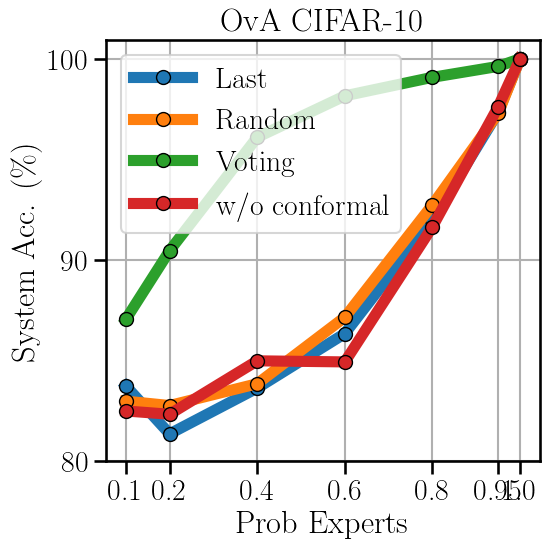

In [ ]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]

sys_acc_standard = np.array([method_d["system_accuracy"] for method_d in method_dict["standard"]])
sys_acc_last = np.array([method_d["system_accuracy"] for method_d in method_dict["last"]])
sys_acc_random = np.array([method_d["system_accuracy"] for method_d in method_dict["random"]])
sys_acc_voting = np.array([method_d["system_accuracy"] for method_d in method_dict["voting"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(p_out, sys_acc_last, label=r"Last", **plot_args)
ax.plot(p_out, sys_acc_random, label=r"Random", **plot_args)
ax.plot(p_out, sys_acc_voting, label=r"Voting", **plot_args)
ax.plot(p_out, sys_acc_standard, label=r"w/o conformal", **plot_args)
plt.xticks(p_out, p_out)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'System Acc. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"OvA CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


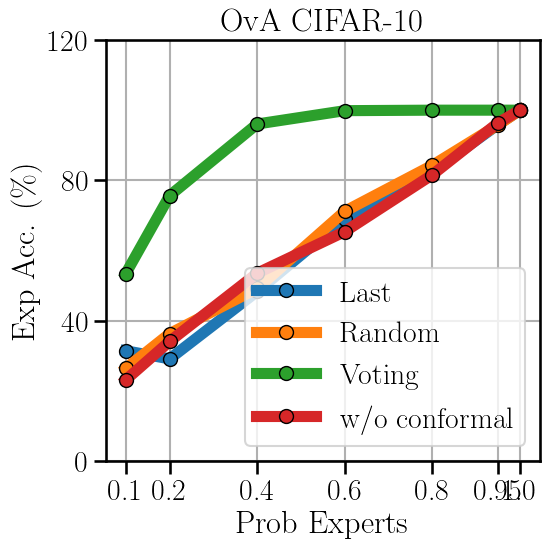

In [ ]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]

exp_acc_standard = np.array([method_d["expert_accuracy"] for method_d in method_dict["standard"]])
exp_acc_last = np.array([method_d["expert_accuracy"] for method_d in method_dict["last"]])
exp_acc_random = np.array([method_d["expert_accuracy"] for method_d in method_dict["random"]])
exp_acc_voting = np.array([method_d["expert_accuracy"] for method_d in method_dict["voting"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(p_out, exp_acc_last, label=r"Last", **plot_args)
ax.plot(p_out, exp_acc_random, label=r"Random", **plot_args)
ax.plot(p_out, exp_acc_voting, label=r"Voting", **plot_args)
ax.plot(p_out, exp_acc_standard, label=r"w/o conformal", **plot_args)
plt.xticks(p_out, p_out)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Exp Acc. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"OvA CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


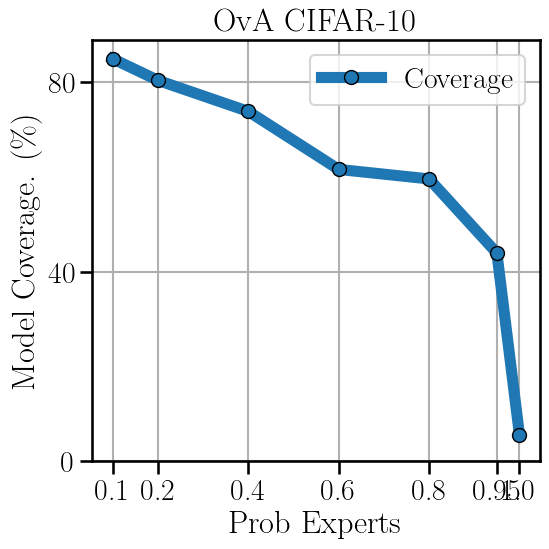

In [15]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
coverage = np.array([method_d["coverage"] for method_d in method_dict["last"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(p_out, coverage, label=r"Coverage", **plot_args)
plt.xticks(p_out, p_out)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Model Coverage. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"OvA CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()
